#### Mistral 7B

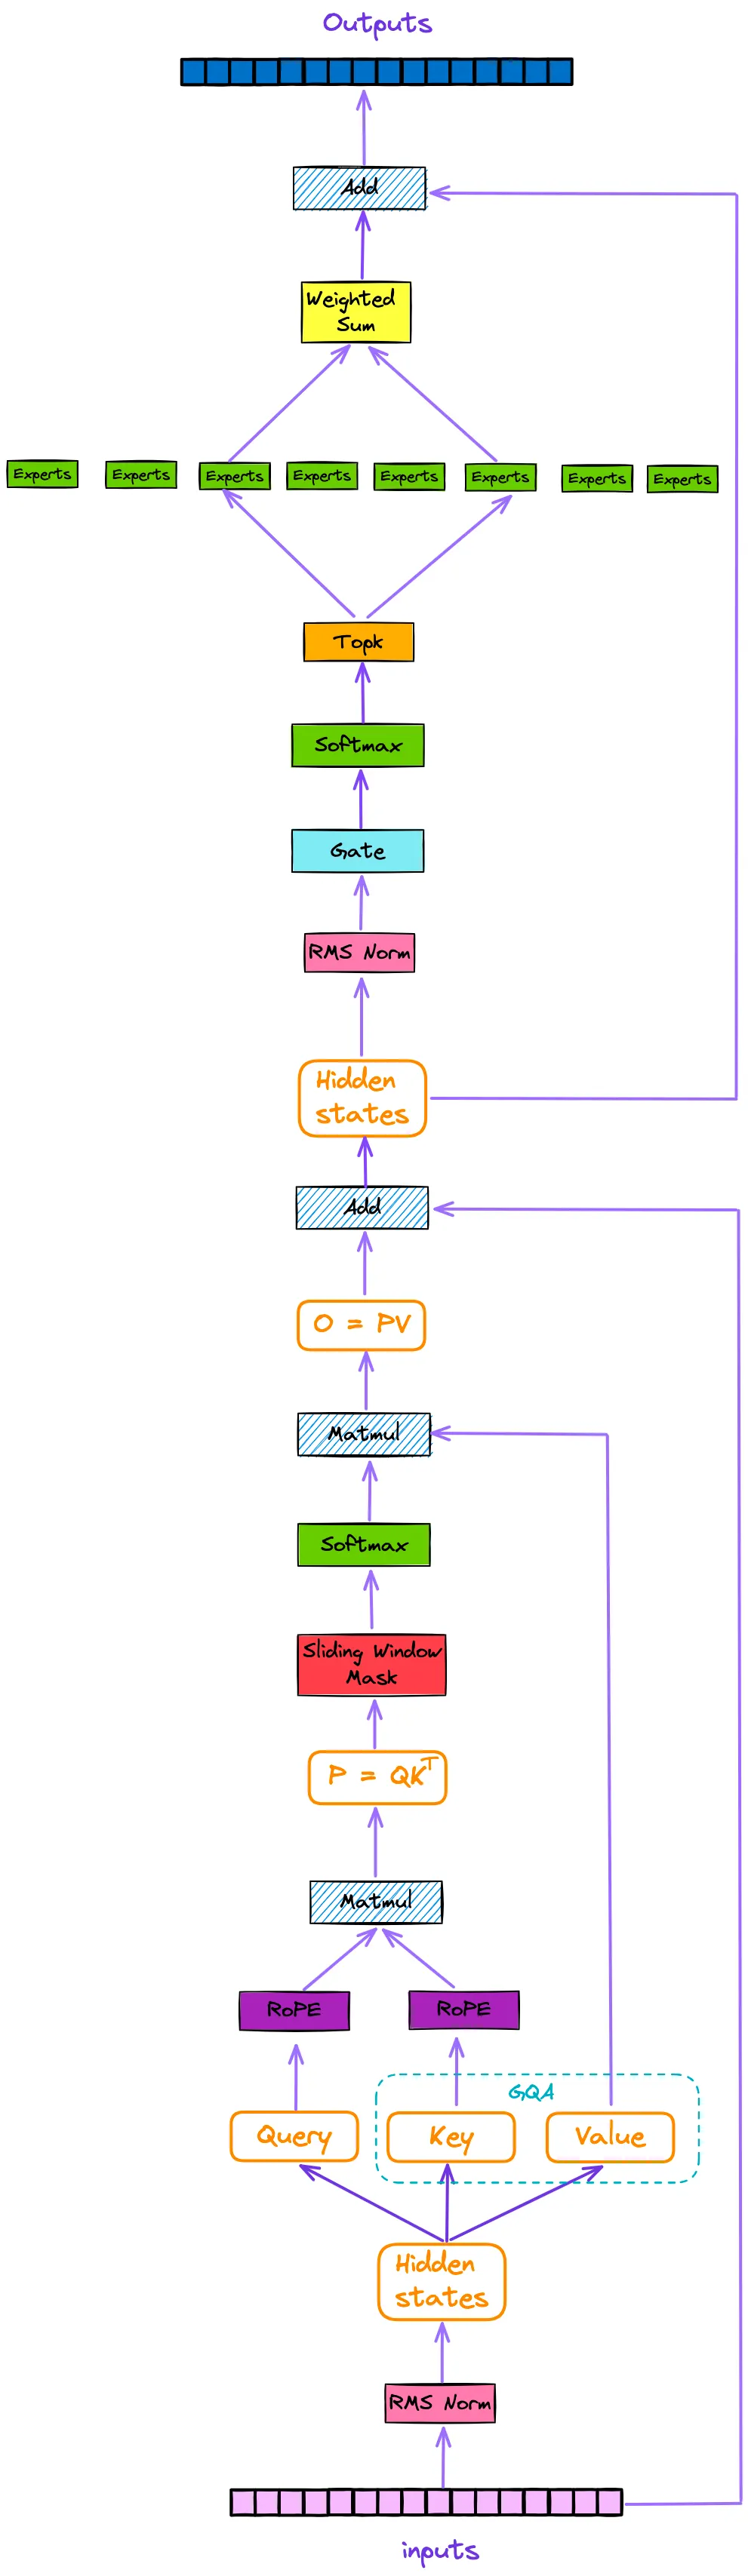

### Sliding Window Attention

The idea is to restrict attention to a local window of size w, which specifies the number of tokens in front of and behind the current token that can be attended to. This reduces the number of tokens each token attends to, thereby improving the time complexity of the attention step from ```O(L_max²)``` to ```O(w * L_max)```. In the encoder, tokens can still attend to other tokens before and after them within the defined window, and in the decoder, tokens continue to attend only to previously generated tokens, preserving the autoregressive property.

However, the range of attention is further restricted to tokens within the sliding window. The primary change introduced by SWA is that the scope of attention is limited to the size of the window, reducing computational overhead without sacrificing the model's ability to process local context.

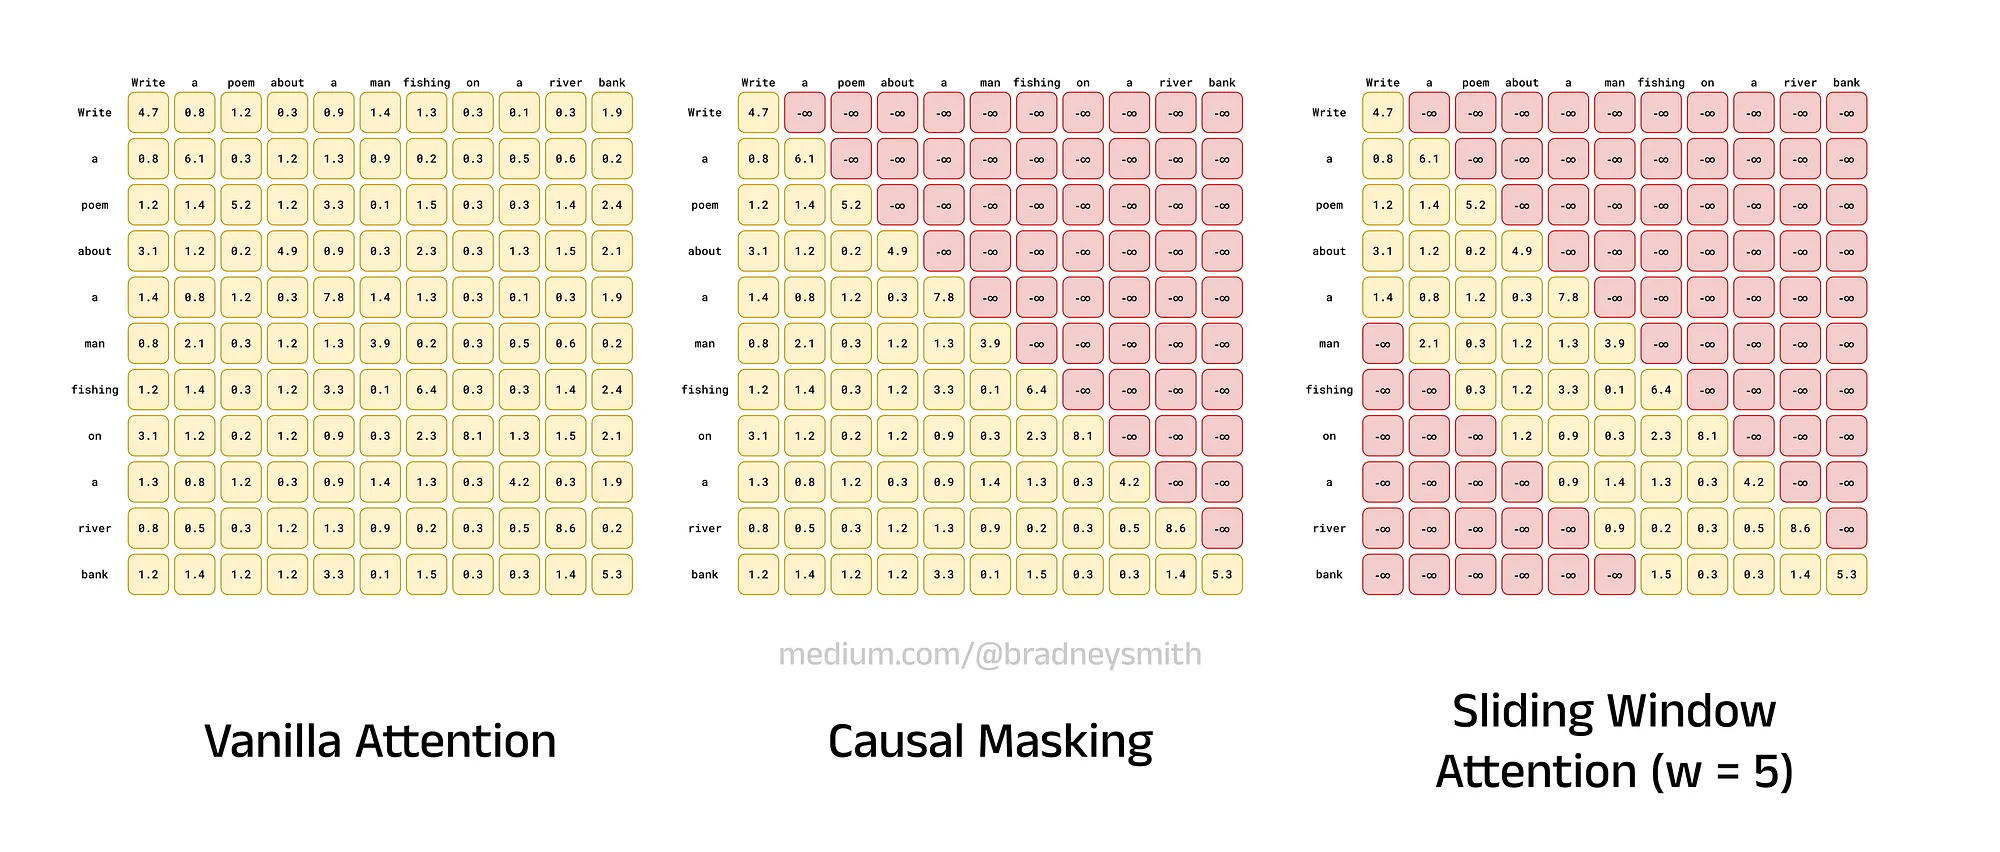

“Rolling Buffer” refers to the Key and Value matrices in the cache only storing information for tokens within the current attention window. As a result, the cache can “forget” tokens outside the local context, significantly reducing memory usage while maintaining the necessary information for accurate token generation.

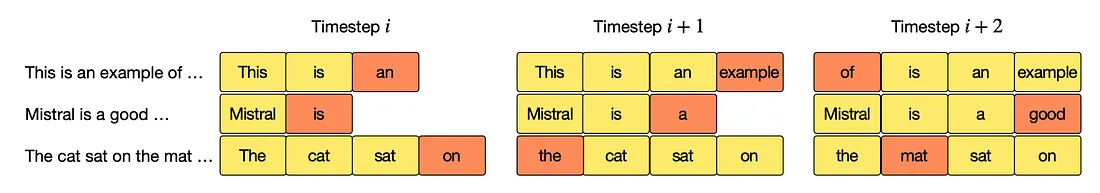

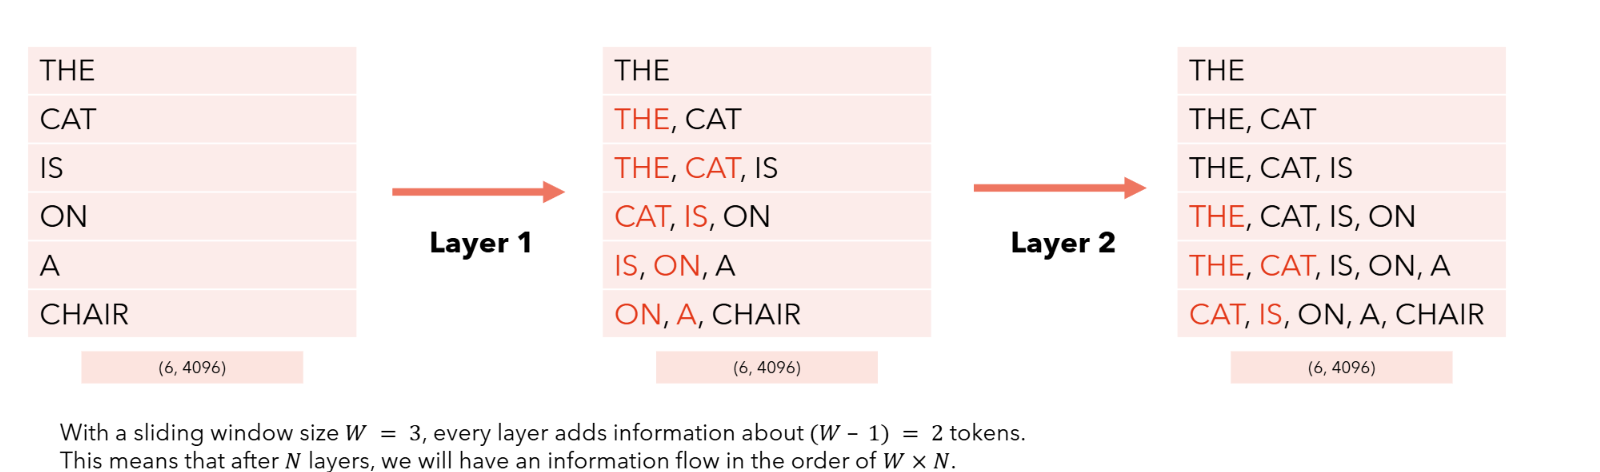

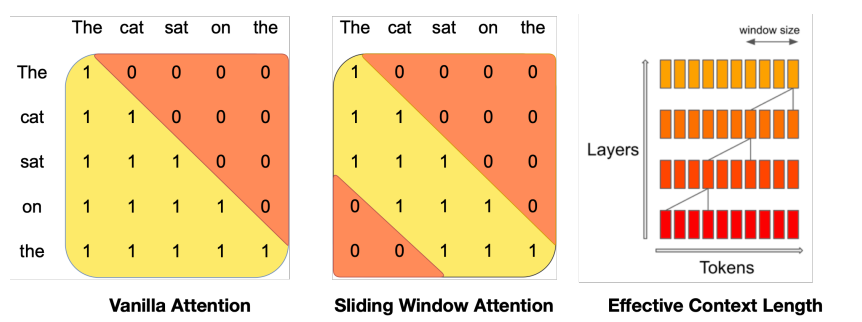

**Window Size**: At each individual layer of the model, a token (represented by a colored block along the "Tokens" axis) can only look back and attend to other tokens within a specific, fixed-size window. This limits the immediate computational complexity, making the model faster and more memory-efficient than standard attention mechanisms which process every preceding token.

**Layers**: As you move up through multiple stacked layers ("Layers" axis), information from earlier in the sequence is gradually integrated. The input to an upper layer is the processed output of the layer below it.

**Effective Context Length**: Through the stacking of these layers, the range of the initial input tokens that can influence the final output for a given token increases. This expanding field of influence across layers is the "effective context length". It allows the model to indirectly capture relationships and dependencies that are much further apart in the original sequence than the single-layer window size would suggest, similar to how a human can infer the overall theme of a paragraph even while only reading a few words at a time

#### Chunk pre-filling


**Pre-filling** refers to populating the KV Cache with the key and value vectors for all tokens in the input sequence prior to incremental inference. This process ensures that the static portion of the input sequence (e.g., a prompt) is fully processed ahead of time, reducing redundant computation when generating new tokens.

**Chunking** addresses the challenge of handling long sequence lengths by dividing the input into fixed-length sections called chunks, equal to the window size of the attention mechanism. To prevent memory overload, the Key and Value matrices for each chunk are calculated separately and iteratively added to the cache. Chunking can then be used during inference as well, as more tokens are generated. Tokens in the newest chunk only attend to themselves and the tokens stored in the previous, cached, chunk (as long as they are within the context window).

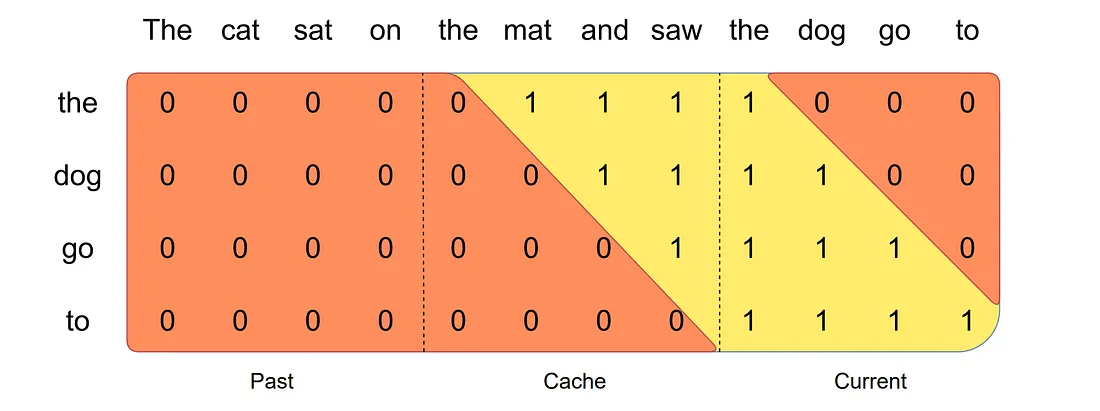


An overview of the KV Cache where the input sequence has been pre-filled across three chunks. Tokens in the final chunk can only attend to themselves and the previous chunk, as long as the tokens are within the local context window

**Core Mechanics**

- SWA restricts attention to a fixed window of tokens, typically set at 4096.
- A token is only capable of attending to a ```window_size``` number of tokens from the preceding layer (e.g., across 32 layers).

- This setup results in a maximum theoretical context size calculated as
$window_{\text{size}} \times n_{\text{layers}}$ which can reach 131K tokens.

**Efficiency**

The primary benefit of SWA is that it reduces attention complexity from quadratic to linear, significantly improving computational efficiency

### KV Cache

- Each round text generation adds a new token to the KV cache.
- Can we avoid recomputing KV values again and again for the previous tokens?
- The KV cache stores the KV values for all previous tokens in the accelerator RAM.
​- Of course, this doesn’t work for the first token, which is why it takes longer to generate. **Time to generate first token is a measure of true Inference - used as a metrics**
​

```Cache size (FP16) = 2 × batch size × seq length × num layers × embed length``` -> Gigabytes.

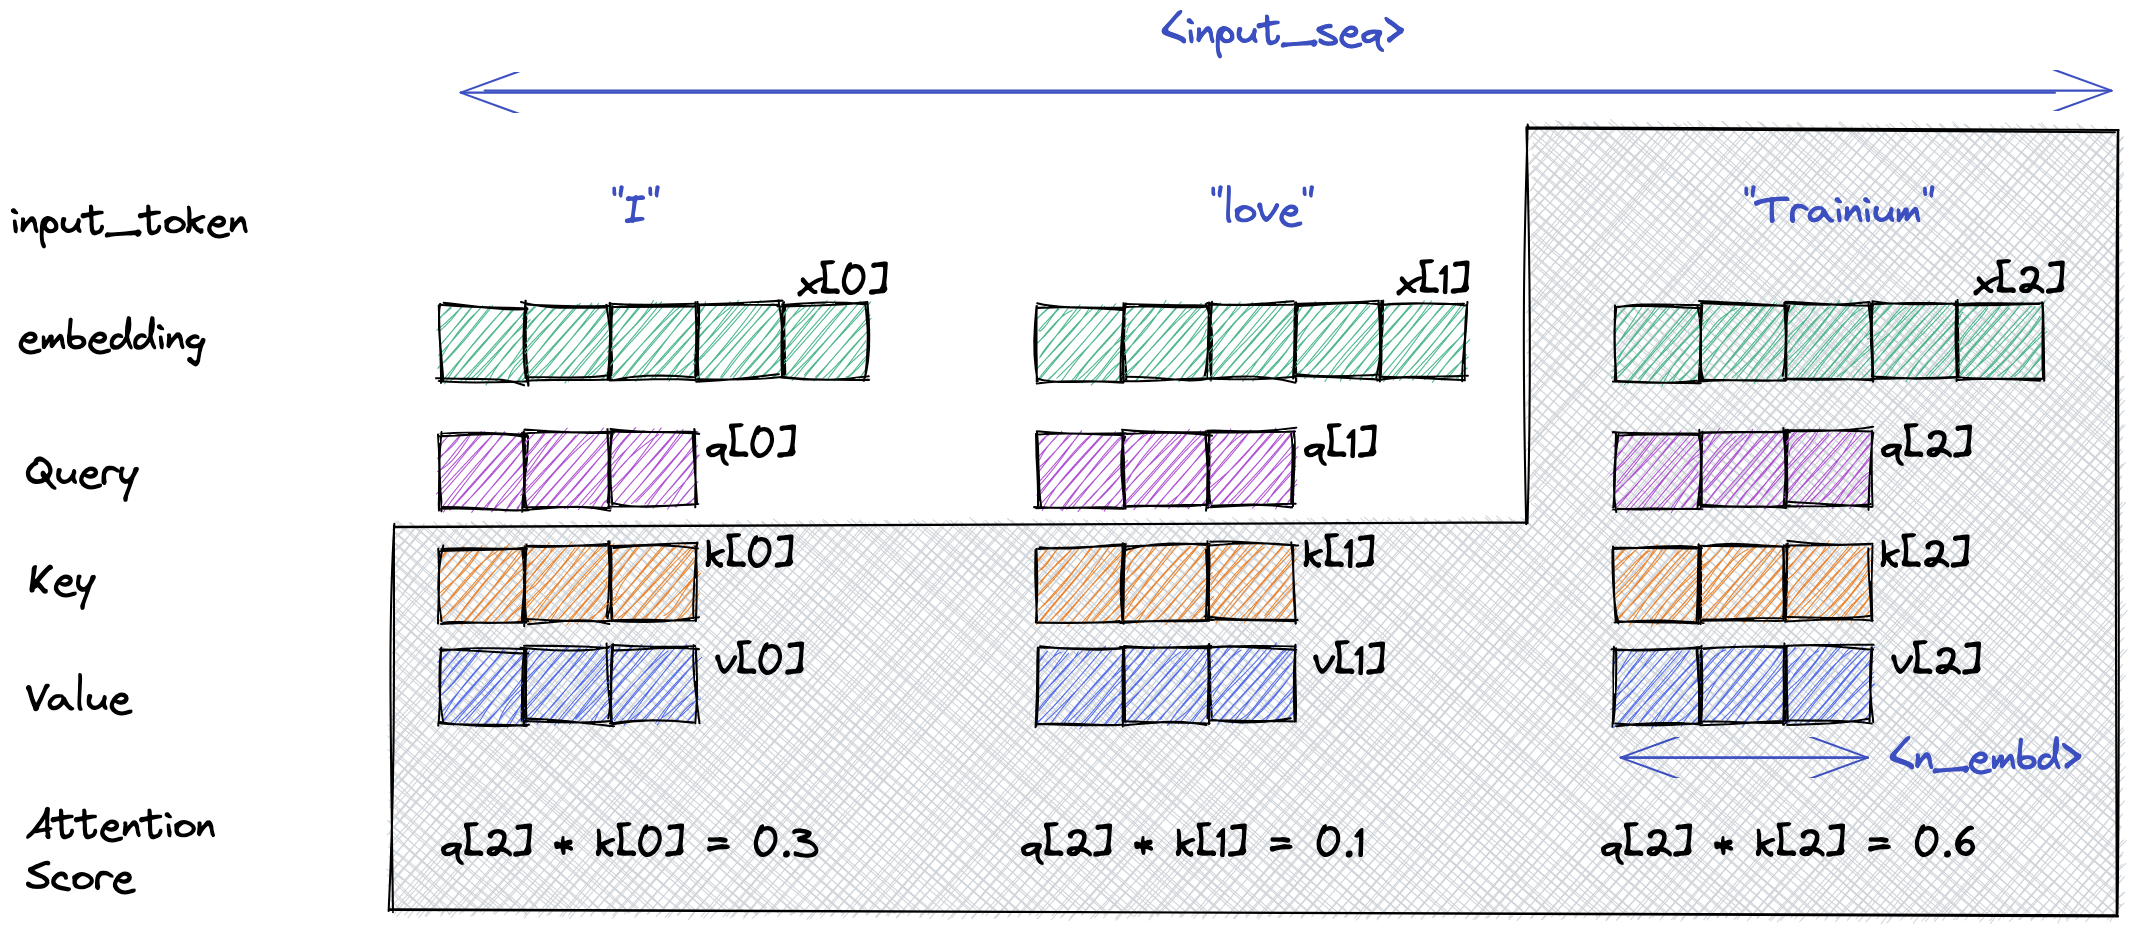

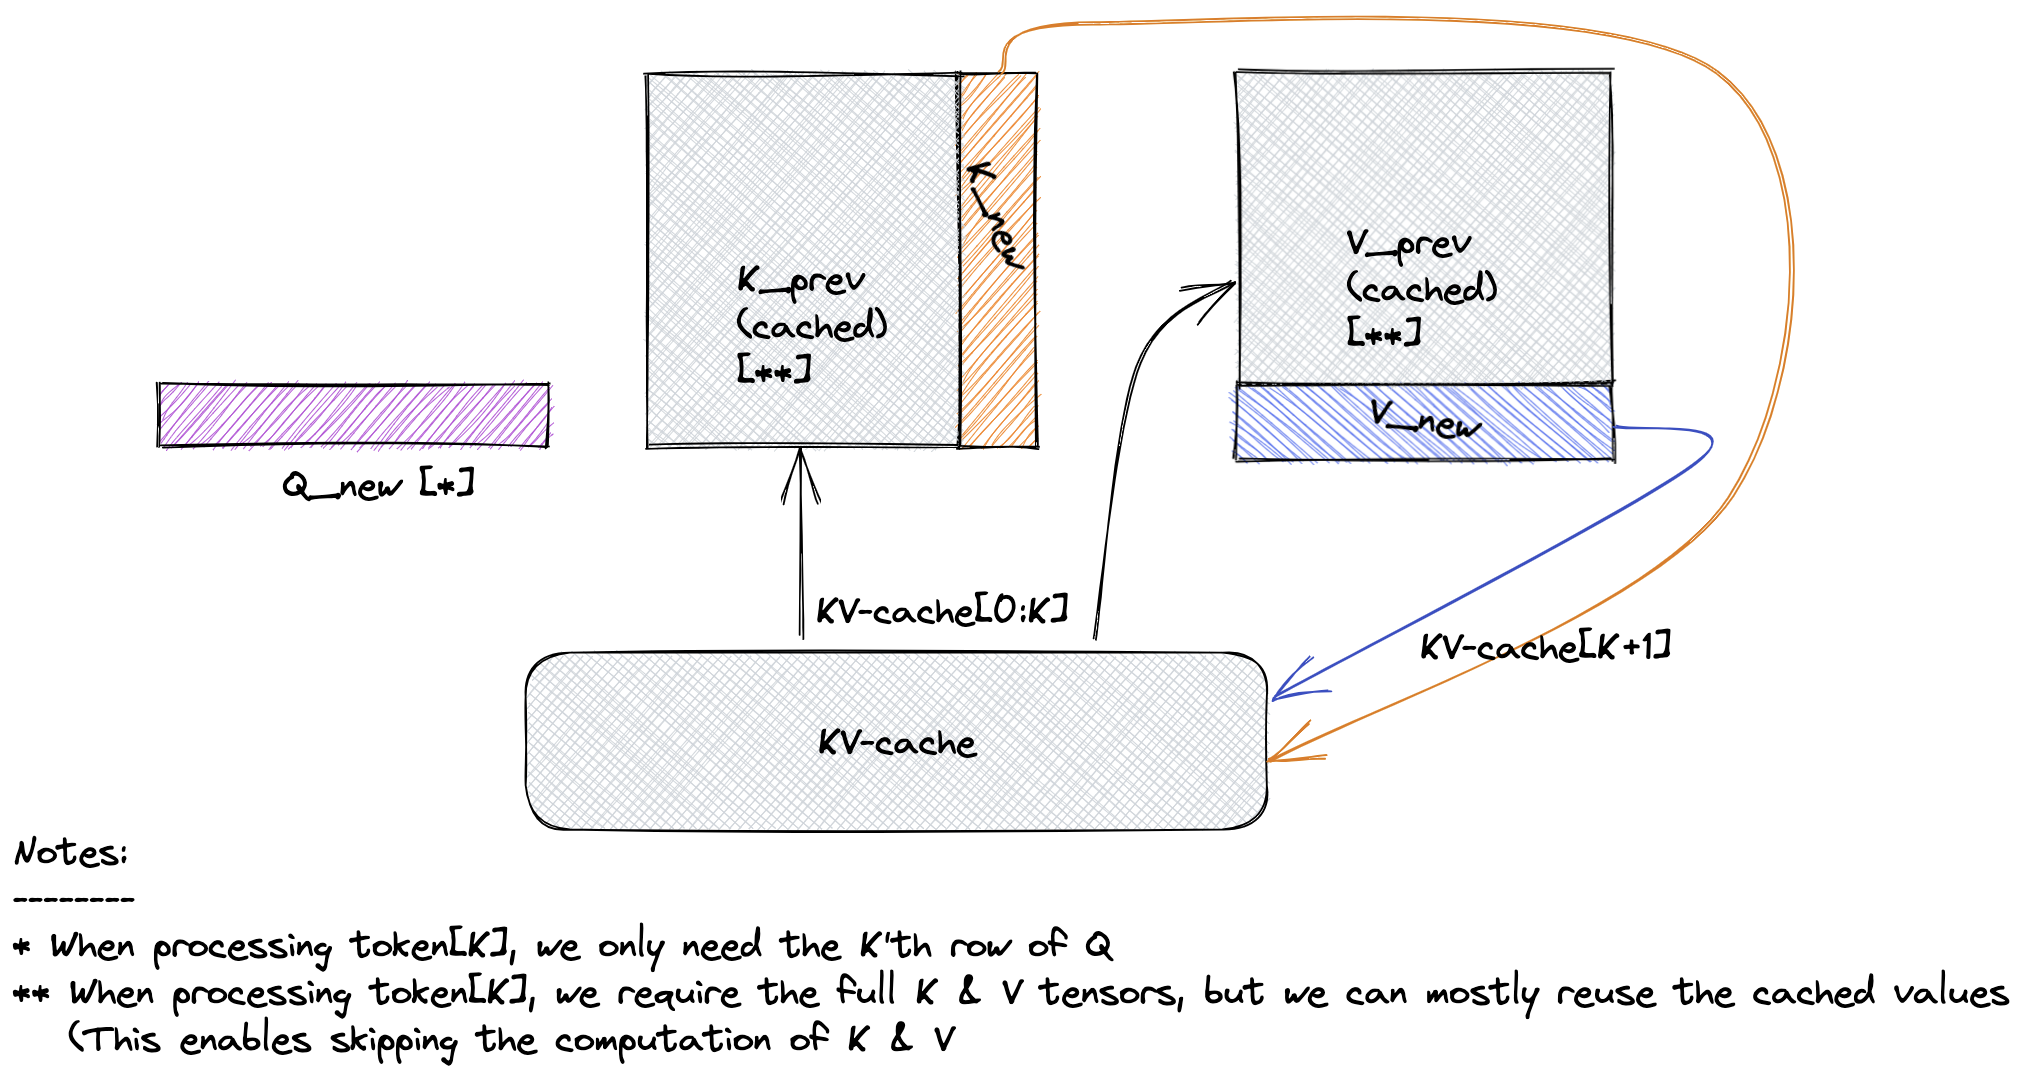

```python
# Use KV cache
model = AutoModelForCausalLM.from_pretrained("gpt2", dtype=torch.float16,

# input["input_ids"].shape: torch.Size([1, 7])

```
    B = batch size
    N = input seq length
    D = model dimension
    H = number of attention heads
    D/H = dimensions per head

Then the dimension of key/value matrix is ```[D, N, D/H] or [B,D, N, D/H]```

for ```D=12 and D/H=64, N = 7, B=1```

```python
query.shape, key.shape, value.shape
(torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]))
```

  


```python
# on dimension of N = seq length
query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)
```

After prefill is done, ```key``` and ```value``` only have parameters for one token:

```python
query.shape, key.shape, value.shape
(torch.Size([1, 12, 1, 64]), torch.Size([1, 12, 1, 64]), torch.Size([1, 12, 1, 64]))
```
then concatenated to the past kv:

```python

if layer_past is not None:
    past_key, past_value = layer_past
    key = torch.cat((past_key, key), dim=2)
    value = torch.cat((past_value, value), dim=2)

>>> key.shape, value.shape
# N+1 token generated i.e 1st token generated
(torch.Size([1, 12, 8, 64]), torch.Size([1, 12, 8, 64]))

```
which saves huge amount of computation for calculating 2 and 3. Note that this does not save computation for 4 and 5; as context is getting longer, K and V size is larger, and matmul takes longer to compute.
